In [12]:
# pip install plotly

In [13]:
"""Evaluation script for the Facebook AI Image Similarity Challenge. This script has a command-line
interface (CLI). See CLI documentation with: `python eval_metrics.py --help`. Note that this script
does not contain any of the input validation on submission files that the competition platform will
do (e.g., validating shape of submission, validating ID values)."""

import json
from pathlib import Path
from typing import Any, List, Optional, Sequence, Tuple

import numpy as np
import pandas as pd
import typer


def argsort(seq: Sequence[Any]):
    """Like np.argsort but for 1D sequences. Based on https://stackoverflow.com/a/3382369/3853462"""
    return sorted(range(len(seq)), key=seq.__getitem__)


def precision_recall(
    y_true: np.ndarray, probas_pred: np.ndarray, num_positives: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute precisions, recalls, and thresholds.

    Parameters
    ----------
    y_true : np.ndarray
        Binary label of each prediction (0 or 1). Shape [n, k] or [n*k, ]
    probas_pred : np.ndarray
        Score of each prediction (higher score == images more similar, ie not a distance)
        Shape [n, k] or [n*k, ]
    num_positives : int
        Number of positives in the groundtruth.

    Returns
    -------
    precisions, recalls, thresholds
        ordered by increasing recall, as for a precision-recall curve
    """
    probas_pred = probas_pred.flatten()
    y_true = y_true.flatten()
    # to handle duplicates scores, we sort (score, NOT(jugement)) for predictions
    # eg,the final order will be (0.5, False), (0.5, False), (0.5, True), (0.4, False), ...
    # This allows to have the worst possible AP.
    # It prevents participants from putting the same score for all predictions to get a good AP.
    order = argsort(list(zip(probas_pred, ~y_true)))
    order = order[::-1]  # sort by decreasing score
    probas_pred = probas_pred[order]
    y_true = y_true[order]

    ntp = np.cumsum(y_true)  # number of true positives <= threshold
    nres = np.arange(len(y_true)) + 1  # number of results

    precisions = ntp / nres
    recalls = ntp / num_positives
    return precisions, recalls, probas_pred


def average_precision(recalls: np.ndarray, precisions: np.ndarray):
    """
    Compute the micro-average precision score (μAP).

    Parameters
    ----------
    recalls : np.ndarray
        Recalls. Must be sorted by increasing recall, as in a PR curve.
    precisions : np.ndarray
        Precisions for each recall value.

    Returns
    -------
    μAP: float
    """

    # Check that it's ordered by increasing recall
    if not np.all(recalls[:-1] <= recalls[1:]):
        raise ValueError("recalls array must be sorted before passing in")
    return ((recalls - np.concatenate([[0], recalls[:-1]])) * precisions).sum()


def find_operating_point(
    x: np.ndarray, y: np.ndarray, z: np.ndarray, required_x: float
) -> Tuple[float, Optional[float], Optional[float]]:
    """
    Find the highest y (and corresponding z) with x at least `required_x`.

    Returns
    -------
    x, y, z
        The best operating point (highest y) with x at least `required_x`.
        If we can't find a point with the required x value, return
        x=required_x, y=None, z=None
    """
    valid_points = x >= required_x
    if not np.any(valid_points):
        return required_x, None, None

    valid_x = x[valid_points]
    valid_y = y[valid_points]
    valid_z = z[valid_points]
    best_idx = np.argmax(valid_y)
    return valid_x[best_idx], valid_y[best_idx], valid_z[best_idx]


def evaluate_metrics(submission_df: pd.DataFrame, gt_df: pd.DataFrame):
    """Given a matching track submission dataframe and a ground truth dataframe,
    compute the competition metrics."""

    # Subset submission_df to query_ids that we have labels for in gt_df
    submission_df = submission_df[submission_df["query_id"].isin(gt_df["query_id"])]

    gt_pairs = {
        tuple(row)
        for row in gt_df[["query_id", "reference_id"]].itertuples(index=False)
        if not pd.isna(row.reference_id)
    }

    # Binary indicator for whether prediction is a true positive or false positive
    y_true = np.array(
        [
            tuple(row) in gt_pairs
            for row in submission_df[["query_id", "reference_id"]].itertuples(index=False)
        ]
    )
    # Confidence score, as if probability. Only property required is greater score == more confident.
    probas_pred = submission_df["score"].values

    p, r, t = precision_recall(y_true, probas_pred, len(gt_pairs))

    # Micro-average precision
    ap = average_precision(r, p)

    # Metrics @ Precision>=90%
    pp90, rp90, tp90 = find_operating_point(p, r, t, required_x=0.9)

    if rp90 is None:
        # Precision was never above 90%
        rp90 = 0.0

    return ap, rp90

In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('white')

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('mode.chained_assignment', None)

%load_ext autoreload
%autoreload 2

import cv2

import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
gt = pd.read_csv('/mnt/sdb/yokoo/fbisc/input/public_ground_truth.csv')
# sub = pd.read_csv('../output/cat_norm_pca_norm_iso.csv')
sub = pd.read_csv('../exp/v89/extract/fb-isc-submission.csv')

sub = sub.merge(gt, how='left', on='query_id', suffixes=('', '_gt'))

sub['correct'] = sub['reference_id'] == sub['reference_id_gt']

sub = sub[sub.query_id.isin(gt.query_id)]

sub = sub.sort_values('score', ascending=False)
max_score = sub.groupby("query_id").first()

In [17]:
import h5py

def load_descriptor_h5(descs_submission_path):
    """Load datasets from descriptors submission hdf5 file."""

    with h5py.File(descs_submission_path, "r") as f:
        query = f["query"][:]
        reference = f["reference"][:]
        # Coerce IDs to native Python unicode string no matter what type they were before
        query_ids = np.array(f["query_ids"][:], dtype=object).astype(str).tolist()
        reference_ids = np.array(f["reference_ids"][:], dtype=object).astype(str).tolist()

        if "train" in f:
            train = f["train"][:]
        else:
            train = None

    return query, reference, train, query_ids, reference_ids

versions = [
#     'v72',
#     'v75',
    'v85',
#     'v87',
]
qs = []
rs = []
ts = []
for ver in versions:
    _query, _reference, _, query_ids, reference_ids = load_descriptor_h5(f'../exp/{ver}/extract/fb-isc-submission.h5')
    _train = np.load(f'../exp/{ver}/extract/train_feats.npy')
    qs.append(_query)
    rs.append(_reference)
    ts.append(_train)

query = np.concatenate(qs, axis=1)
reference = np.concatenate(rs, axis=1)
train = np.concatenate(ts, axis=1)


- 1枚のref画像に対して、複数のquery画像が紐付いている場合がある
- ラベルノイズが多い。score上位で間違えているものは実は合っているものがほとんど。
- query単体で見るとtop1は合ってるけど、top2もかなり似ているがゆえにscore高めに出てしまうことがある。
- top1だけ類似度が高くなって、他は低くなるような変換なにかないか
- 平均ベクトルを類似度をもとに

- emb isoもっといい方法ありそう。similarityは流石に使いたい。
- 画像混ぜるやつ入れたい。（レイヤーする側。背景は関係ないtrainのやつ使う。レイヤーする側だけaugするとかもやる。透過具合もコントロールする。）
- deepfake入れたい？
- layer detection うまいことlayerの部分だけ切り抜けるように学習させて、抽出時はその部分だけで評価するようにする。
    - そのとき絵文字みたいなのを検出しないようにする。SNSはめ込みなど、複数検出候補があるときはどうする？
    - layerは必ずしも四角形ではなく、端っこの方がぼやけているような感じでlayerされているときもある
    - 背景のほうがターゲットのときもあった。なのでlayer detectionは微妙そう

In [29]:
# gt_refs = gt.reference_id[gt.reference_id.notna()]
# failed_refs = gt_refs[~gt_refs.isin(sub.reference_id.unique())]

# first_correct = sub.groupby('query_id')['correct'].first()
# notnan = sub.groupby('query_id')['reference_id_gt'].first().notna()
# difficult_qids = first_correct[(~first_correct) & notnan].index
# np.save('../output/difficult_qids.npy', difficult_qids)
difficult_qids = np.load('../output/difficult_qids.npy', allow_pickle=True)

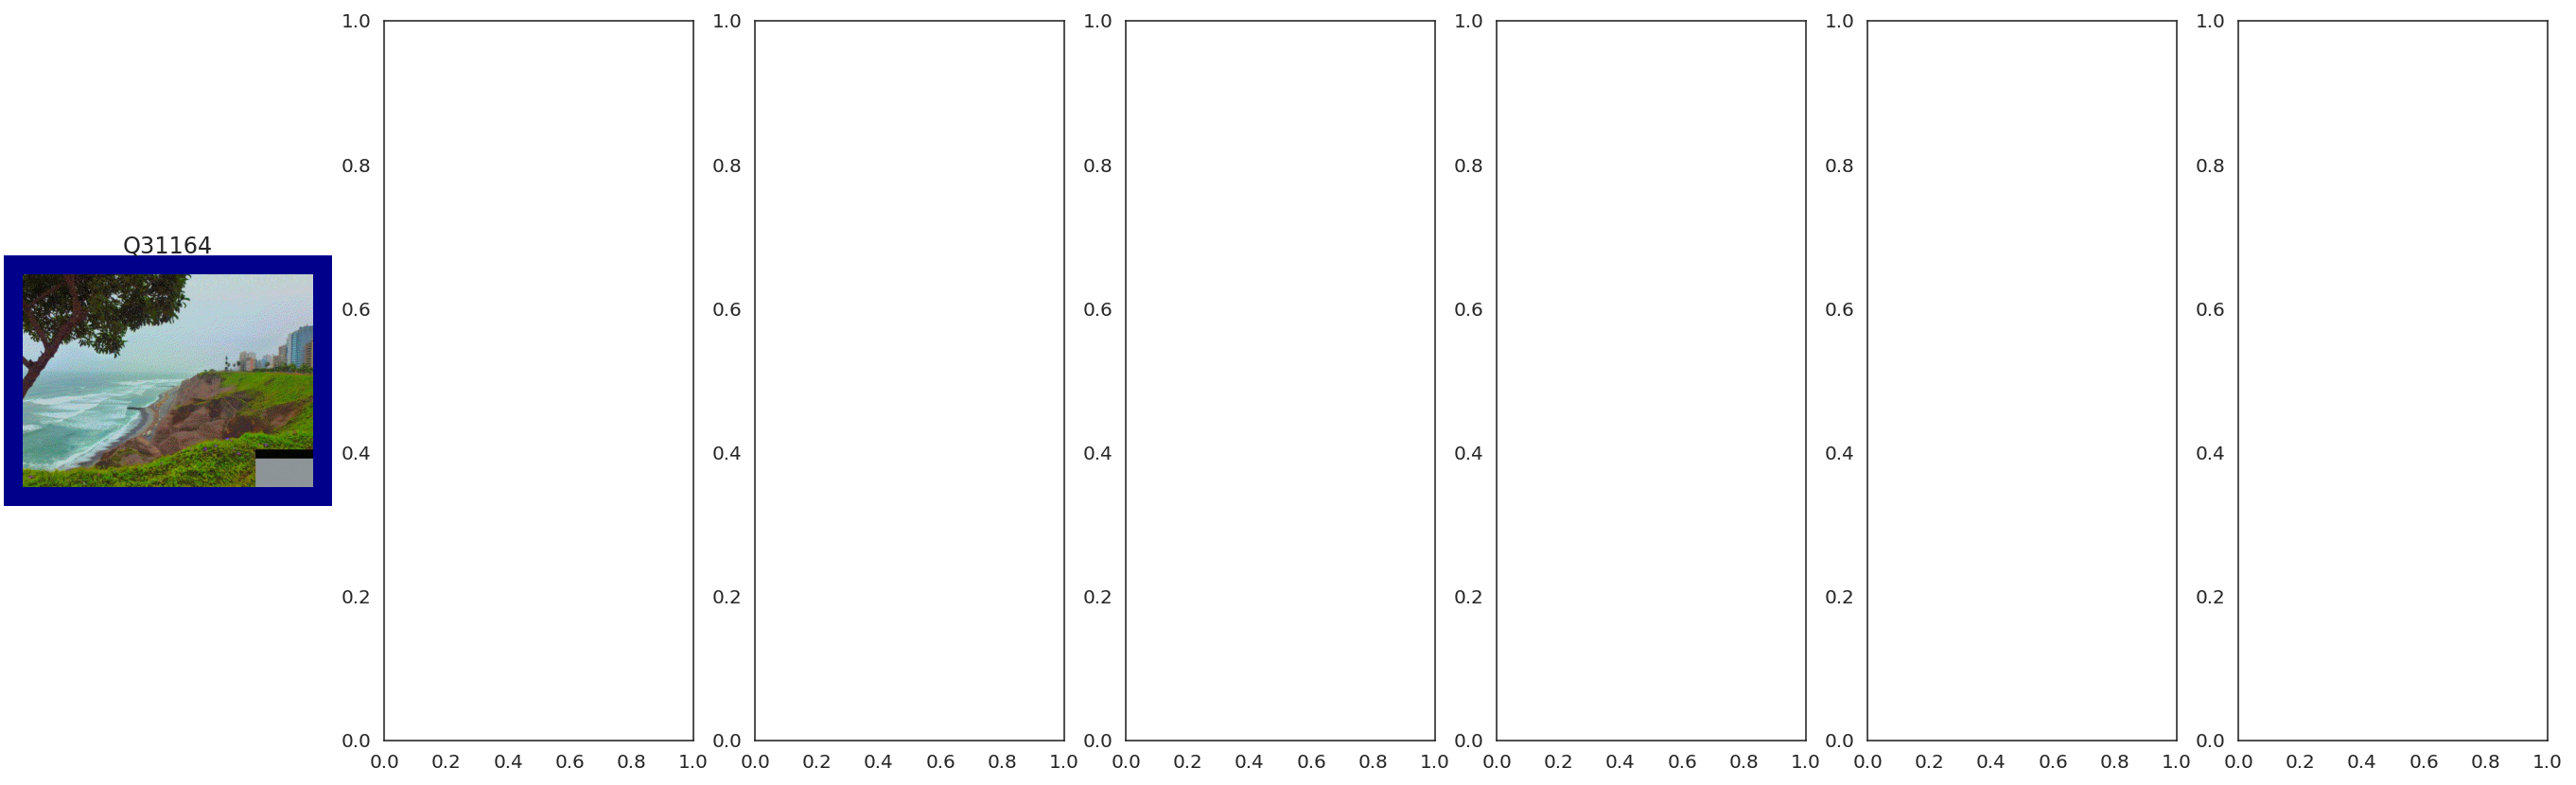

In [22]:
qid = 'Q31164'
# qid = gt[gt.reference_id.isin(failed_refs)].sample(100).query_id.iloc[0]
# qid = np.random.choice(difficult_qids)

k = 5
nrows = 1
ncols = k + 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 7))

df = sub[sub['query_id'] == qid]
qimg = cv2.imread(f"../input/query_images/{qid}.jpg")[:, :, ::-1]

ax[0].imshow(qimg)
ax[0].set_title(qid)
for loc in ["top", "left", "bottom", "right"]:
    ax[0].spines[loc].set_linewidth(10)
    ax[0].spines[loc].set_color('darkblue')
ax[0].axes.xaxis.set_ticks([])
ax[0].axes.yaxis.set_ticks([])

for i, (_, row) in enumerate(df.iterrows()):
    if i == k:
        break
    rimg = cv2.imread(f"../input/reference_images/{row['reference_id']}.jpg")[:, :, ::-1]
    ax[i+1].imshow(rimg)
    ax[i+1].set_title(f"{row['reference_id']}: score={row['score']:.2f}")
    color = 'limegreen' if row['reference_id'] == row['reference_id_gt'] else 'firebrick'
    for loc in ["top", "left", "bottom", "right"]:
        ax[i+1].spines[loc].set_linewidth(10)
        ax[i+1].spines[loc].set_color(color)
    ax[i+1].axes.xaxis.set_ticks([])
    ax[i+1].axes.yaxis.set_ticks([])

# if not df.correct.any() and gt[gt.query_id == qid]['reference_id'].notna().item():
#     row = gt[gt.query_id == qid]
#     rimg = cv2.imread(f"../input/reference_images/{row['reference_id'].item()}.jpg")[:, :, ::-1]

#     qidx = int(row.query_id.item()[1:])
#     ridx = int(row.reference_id.item()[1:])
#     score = - np.sum((query[qidx] - reference[ridx]) ** 2) ** 0.5
    
#     ax[-1].imshow(rimg)
# #     ax[-1].set_title(f"{row['reference_id'].item()}: score={score:.2f}")

In [548]:
gt_ = gt[gt['reference_id'].notna()]
query_paths = [f'../input/query_images/{qid}.jpg' for qid in gt_['query_id']]
query_paths = [f'../input/query_images/{qid}.jpg' for qid in gt_['query_id']]

['../input/query_images/Q00003.jpg',
 '../input/query_images/Q00004.jpg',
 '../input/query_images/Q00008.jpg',
 '../input/query_images/Q00026.jpg',
 '../input/query_images/Q00028.jpg',
 '../input/query_images/Q00029.jpg',
 '../input/query_images/Q00031.jpg',
 '../input/query_images/Q00035.jpg',
 '../input/query_images/Q00037.jpg',
 '../input/query_images/Q00046.jpg',
 '../input/query_images/Q00049.jpg',
 '../input/query_images/Q00051.jpg',
 '../input/query_images/Q00058.jpg',
 '../input/query_images/Q00061.jpg',
 '../input/query_images/Q00063.jpg',
 '../input/query_images/Q00065.jpg',
 '../input/query_images/Q00071.jpg',
 '../input/query_images/Q00073.jpg',
 '../input/query_images/Q00083.jpg',
 '../input/query_images/Q00084.jpg',
 '../input/query_images/Q00089.jpg',
 '../input/query_images/Q00096.jpg',
 '../input/query_images/Q00109.jpg',
 '../input/query_images/Q00113.jpg',
 '../input/query_images/Q00117.jpg',
 '../input/query_images/Q00123.jpg',
 '../input/query_images/Q00128.jpg',
 

In [195]:
evaluate_metrics(sub, gt), evaluate_metrics(sub[sub.query_id.isin(difficult_qids)], gt[gt.query_id.isin(difficult_qids)])

((0.6694047251441112, 0.5944700460829493), (0.004809251871527039, 0.0))

In [490]:
evaluate_metrics(sub, gt), evaluate_metrics(sub[sub.query_id.isin(difficult_qids)], gt[gt.query_id.isin(difficult_qids)])

((0.6216224047514121, 0.5043077539571228), (0.009187991503064943, 0.0))

In [30]:
# v84
evaluate_metrics(sub, gt), evaluate_metrics(sub[sub.query_id.isin(difficult_qids)], gt[gt.query_id.isin(difficult_qids)])

((0.6266863798687519, 0.5249449008214787),
 (0.01976776460872939, 0.0007072135785007072))

In [ ]:
# v85
evaluate_metrics(sub, gt), evaluate_metrics(sub[sub.query_id.isin(difficult_qids)], gt[gt.query_id.isin(difficult_qids)])

In [ ]:
def load_images(row):
    qimg = cv2.imread(f"../input/query_images/{row['query_id']}.jpg")[:, :, ::-1]
    rimg = cv2.imread(f"../input/reference_images/{row['reference_id']}.jpg")[:, :, ::-1]
    return qimg, rimg

qimg, rimg = load_images(sub.iloc[217180])

max_score[max_score.reference_id_gt.notna()].iloc[:100]
max_score.iloc[-100:]

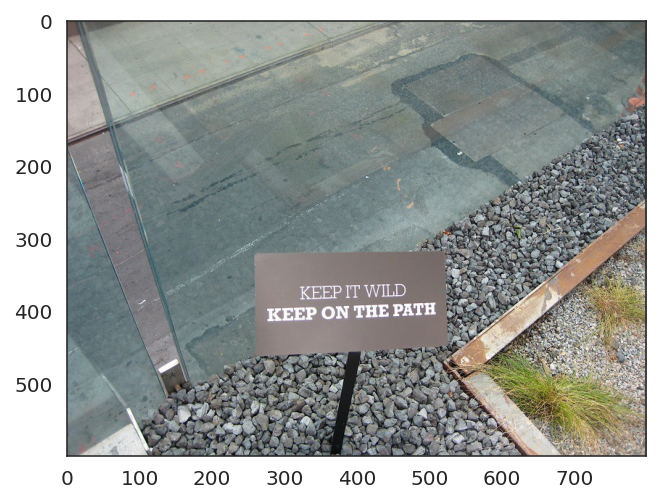

In [21]:
rid = 'R686439'
rimg = cv2.imread(f"../input/reference_images/{rid}.jpg")[:, :, ::-1]
plt.imshow(rimg)

In [23]:
sub[sub['query_id'] == qid]

query_id reference_id    score reference_id_gt  correct
249165   Q24919      R574622 -1.22423         R686439    False
249166   Q24919      R926625 -1.25945         R686439    False
249167   Q24919      R427100 -1.26866         R686439    False
249168   Q24919      R035481 -1.27090         R686439    False
249169   Q24919      R492848 -1.27714         R686439    False
249170   Q24919      R097868 -1.28086         R686439    False
249171   Q24919      R273291 -1.28943         R686439    False
249172   Q24919      R907700 -1.30364         R686439    False
249173   Q24919      R567558 -1.30850         R686439    False
249174   Q24919      R795619 -1.31150         R686439    False
249175   Q24919      R920500 -1.31404         R686439    False
249176   Q24919      R798846 -1.31638         R686439    False

In [267]:
import timm
import torch
import torch.nn as nn

In [243]:
backbone = timm.create_model('tf_efficientnetv2_m_in21ft1k', features_only=True, out_indices=[3, 4])

In [377]:
x = torch.rand((2, 3, 224, 224))

In [409]:
y = backbone(x)

In [410]:
conv = torch.nn.Conv2d(3, 128, kernel_size=3, padding=9, dilation=9)

In [411]:
conv(x).shape

torch.Size([2, 128, 224, 224])

In [412]:
torch.norm(
    x / torch.norm(x, dim=(2, 3), keepdim=True),
    dim=(2, 3)
)

tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]])

In [413]:
import argparse
import builtins
import math
import os
import pickle
import random
import shutil
import subprocess
from typing import Any, Dict, List, Optional
import warnings
from pathlib import Path

import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.activation import ReLU
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import timm
from PIL import Image, ImageFilter
from tqdm import tqdm
from pytorch_metric_learning.utils import distributed as pml_dist
from pytorch_metric_learning import losses
from augly.image.functional import overlay_emoji, overlay_text, overlay_image
from augly.image.transforms import BaseTransform
from augly.utils.constants import FONTS_DIR, FONT_LIST_PATH, SMILEY_EMOJI_DIR
from augly.utils.base_paths import MODULE_BASE_DIR
from augly.utils import pathmgr
from augly.image import (
    EncodingQuality,
    OverlayOntoScreenshot,
    RandomBlur,
    RandomEmojiOverlay,
    RandomPixelization,
    RandomRotation,
    ShufflePixels,
    OneOf,
)

class DOLGLocalBranch(nn.Module):

    def __init__(
        self,
        in_channels,
        base_dim=128,
        dilations=(6, 12, 18),
    ):
        super().__init__()
        self.multi_atrous = nn.ModuleList([
            nn.Sequential(nn.Conv2d(in_channels, base_dim, kernel_size=1), nn.ReLU(inplace=True)),
            nn.Conv2d(in_channels, base_dim, kernel_size=3, padding=dilations[0], dilation=dilations[0]),
            nn.Conv2d(in_channels, base_dim, kernel_size=3, padding=dilations[1], dilation=dilations[1]),
            nn.Conv2d(in_channels, base_dim, kernel_size=3, padding=dilations[2], dilation=dilations[2]),
        ])
        self.mid = nn.Sequential(
            nn.Conv2d(base_dim * 4, base_dim * 2, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_dim * 2, base_dim * 2, kernel_size=1),
            nn.BatchNorm2d(base_dim * 2),
        )
        self.attention_map = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(base_dim * 2, base_dim * 2, kernel_size=1),
            nn.Softplus(),
        )
    
    def forward(self, x):
        outputs = []
        for m in self.multi_atrous:
            outputs.append(m(x))

        x = torch.cat(outputs, dim=1)
        x = self.mid(x)

        attention_map = self.attention_map(x)
        # normalized_x = x / (torch.linalg.norm(x, dim=(1,), keepdim=True) + 1e-9)
        normalized_x = x / (torch.linalg.norm(x, dim=(2, 3), keepdim=True) + 1e-9)

        return attention_map * normalized_x


class DOLGFusionModule(nn.Module):

    def __init__(self):
        super().__init__()
    
    def forward(self, local_feat, global_feat):
        norm_g = torch.linalg.norm(global_feat, dim=1, keepdim=True)
        cosine = torch.einsum('bcn,bc->bn', local_feat, global_feat) / norm_g
        proj = torch.einsum('bn,bc->bcn', cosine, global_feat)
        orth = local_feat - proj

        cat = torch.cat([global_feat.unsqueeze(-1), orth], dim=-1)
        agg = torch.mean(cat, dim=-1)

        return agg


def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)


class ISCNet(nn.Module):

    def __init__(
        self, backbone, fc_dim=256, p=3.0, eval_p=4.0, dilations=(6, 12, 18),
    ):
        super().__init__()

        self.backbone = backbone
        self.local_branch = DOLGLocalBranch(
            in_channels=backbone.feature_info.channels()[0],
            base_dim=backbone.feature_info.channels()[1] // 2,
            dilations=dilations,
        )
        self.fusion = DOLGFusionModule()
        self.fc = nn.Linear(self.backbone.feature_info.info[-1]['num_chs'], fc_dim, bias=False)
        self.bn = nn.BatchNorm1d(fc_dim)
        self._init_params()
        self.p = p
        self.eval_p = eval_p

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)

        local_feat = self.local_branch(x[0])
        local_feat = local_feat.view(batch_size, local_feat.shape[1], -1)
        p = self.p if self.training else self.eval_p
        global_feat = gem(x[1], p).view(batch_size, -1)

        x = self.fusion(local_feat, global_feat)

        x = self.fc(x)
        x = self.bn(x)
        x = F.normalize(x)
        return x

In [463]:
backbone = timm.create_model('tf_efficientnetv2_m_in21ft1k', features_only=True, pretrained=True, out_indices=[3, 4])
model = ISCNet(backbone, p=1.0, eval_p=1.0)

In [464]:
yy = backbone(x)

In [ ]:
class DOLGLocalBranch(nn.Module):

    def __init__(
        self,
        in_channels,
        base_dim=128,
        dilations=(6, 12, 18),
    ):
        super().__init__()
        self.multi_atrous = nn.ModuleList([
            nn.Sequential(nn.Conv2d(in_channels, base_dim, kernel_size=1), nn.ReLU(inplace=True)),
            nn.Conv2d(in_channels, base_dim, kernel_size=3, padding=dilations[0], dilation=dilations[0]),
            nn.Conv2d(in_channels, base_dim, kernel_size=3, padding=dilations[1], dilation=dilations[1]),
            nn.Conv2d(in_channels, base_dim, kernel_size=3, padding=dilations[2], dilation=dilations[2]),
        ])
        self.mid = nn.Sequential(
            nn.Conv2d(base_dim * 4, base_dim * 2, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_dim * 2, base_dim * 2, kernel_size=1),
            nn.BatchNorm2d(base_dim * 2),
        )
        self.attention_map = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(base_dim * 2, base_dim * 2, kernel_size=1),
            nn.Softplus(),
        )
    
    def forward(self, x):
        outputs = []
        for m in self.multi_atrous:
            outputs.append(m(x))

        x = torch.cat(outputs, dim=1)
        x = self.mid(x)

        attention_map = self.attention_map(x)
        normalized_x = x / (torch.linalg.norm(x, dim=(1,), keepdim=True) + 1e-9)
        # normalized_x = x / (torch.linalg.norm(x, dim=(2, 3), keepdim=True) + 1e-9)

        return attention_map * normalized_x


class DOLGFusionModule(nn.Module):

    def __init__(self):
        super().__init__()
    
    def forward(self, local_feat, global_feat):
        norm_g = torch.linalg.norm(global_feat, dim=1, keepdim=True)
        cosine = torch.einsum('bcn,bc->bn', local_feat, global_feat) / norm_g
        proj = torch.einsum('bn,bc->bcn', cosine, global_feat)
        orth = local_feat - proj

        cat = torch.cat([global_feat.unsqueeze(-1), orth], dim=-1)
        agg = torch.mean(cat, dim=-1)

        return agg

In [465]:
l = DOLGLocalBranch(backbone.feature_info.channels()[0])
local_feat = l(y[0]).view(2, 512, -1)

In [466]:
global_feat = y[1][:, :, 0, 0]

In [468]:
local_feat.shape, global_feat.shape

(torch.Size([2, 512, 98]), torch.Size([2, 512]))

In [469]:
y[0].shape

torch.Size([2, 176, 14, 14])

In [470]:
enc = nn.TransformerEncoderLayer(512, 8, batch_first=True)

In [ ]:
nn.TransformerEncoder

In [472]:
local_feat.transpose(2, 1).shape

torch.Size([2, 98, 512])

In [473]:
enc(local_feat.transpose(2, 1)).shape

torch.Size([2, 98, 512])

In [475]:
global_feat = y[1].view(2, 512, -1)

In [476]:
dec = nn.TransformerDecoderLayer(512, 8, batch_first=True)

In [478]:
dec(local_feat.transpose(2, 1), global_feat.transpose(2, 1)).shape

torch.Size([2, 98, 512])

In [427]:
norm_g = torch.linalg.norm(global_feat, dim=1, keepdim=True)
cosines = torch.einsum('bcn,bc->bn', local_feat, global_feat) / norm_g

proj = torch.einsum('bn,bc->bcn', cosines, global_feat)

orth = local_feat - proj

global_feat.shape

cat = torch.cat([global_feat.unsqueeze(-1), orth], dim=-1)

agg = torch.mean(cat, dim=-1)

In [428]:
local_feat.shape

torch.Size([2, 512, 98])

In [429]:
norm = local_feat / torch.linalg.norm(local_feat, dim=1, keepdim=True)

In [435]:
global_feat.shape

torch.Size([2, 512])

In [430]:
torch.linalg.norm(norm, dim=1).shape

torch.Size([2, 98])

In [431]:
a = local_feat.mean(dim=-1)

In [436]:
torch.bmm(a.unsqueeze(1), global_feat.unsqueeze(2)).squeeze(-1).squeeze(-1).shape

torch.Size([2])

In [437]:
local_feat = local_feat.mean(dim=-1)

In [448]:
a=torch.einsum('bc,bc->b', local_feat, global_feat).unsqueeze(-1) / norm_g
a.shape

torch.Size([2, 1])

In [444]:
norm_g.shape

torch.Size([2, 1])

In [442]:
local_feat.shape, global_feat.shape

(torch.Size([2, 512]), torch.Size([2, 512]))

In [438]:
(local_feat @ global_feat.t()).squeeze(1)

tensor([[ 0.9455, -1.6526],
        [ 1.3029, -2.0326]], grad_fn=<SqueezeBackward1>)

In [349]:
orth.shape

torch.Size([1, 512, 196])

In [ ]:
gt = pd.read_csv('/mnt/sdb/yokoo/fbisc/input/public_ground_truth.csv')

In [197]:
tmp = gt[gt['reference_id'].notna()]


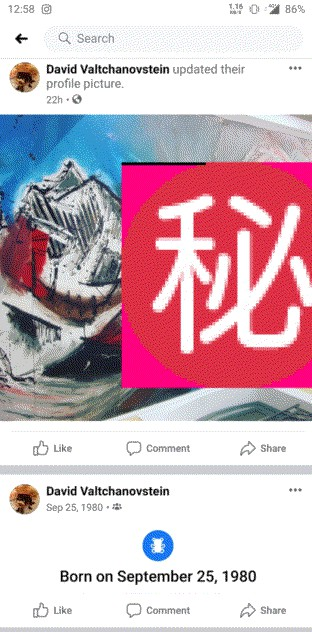

In [198]:
i = 2013
qid, rid = tmp.iloc[i]

qimg = cv2.imread(f'/mnt/sdb/yokoo/fbisc/input/query_images/{qid}.jpg')[:,:,::-1]
px.imshow(qimg)


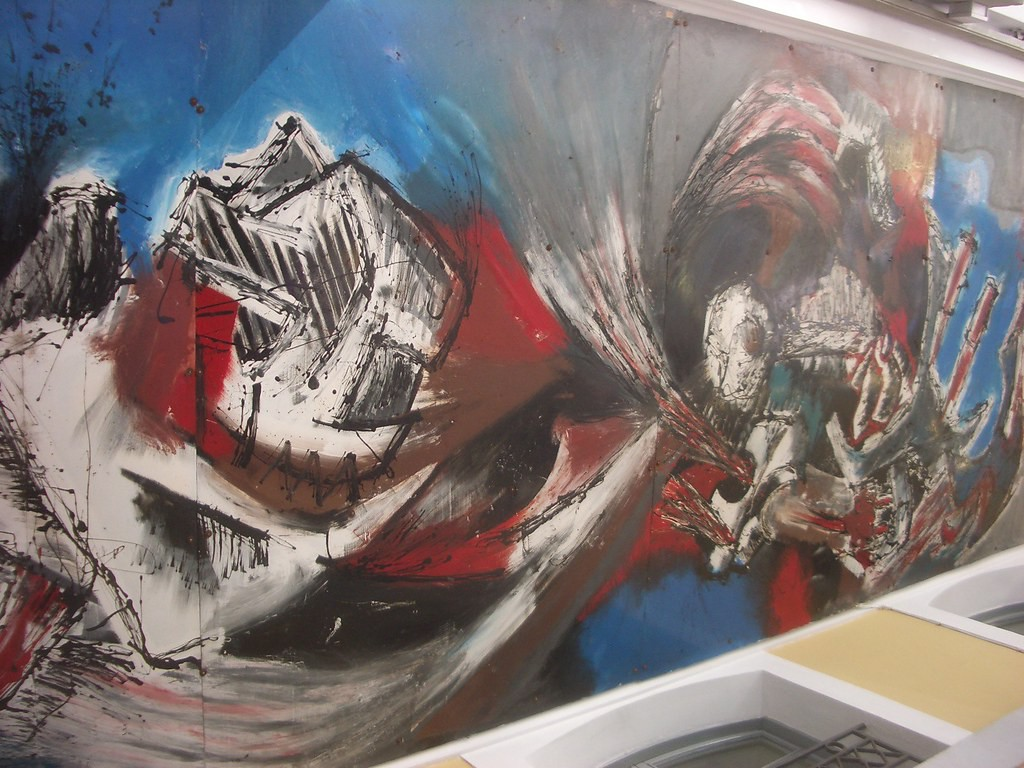

In [199]:
# if isinstance(rid, str):
rimg = cv2.imread(f'/mnt/sdb/yokoo/fbisc/input/reference_images/{rid}.jpg')[:,:,::-1]
px.imshow(rimg)

In [221]:
import augly.image as imaugs

import torchvision.transforms as transforms
from PIL import Image, ImageFilter
from augly.image import (
    EncodingQuality,
    OverlayOntoScreenshot,
    RandomBlur,
    RandomBrightness,
    RandomPixelization,
    Saturation,
    ShufflePixels,
    OneOf,
    OverlayImage,
    ConvertColor,
)
import pickle

from augly.image.functional import overlay_emoji, overlay_text, overlay_image
from augly.image.transforms import BaseTransform
from augly.utils.constants import FONT_PATH, SMILEY_EMOJI_DIR
from augly.utils.constants import FONTS_DIR, FONT_LIST_PATH, SMILEY_EMOJI_DIR
from augly.utils.base_paths import MODULE_BASE_DIR
from augly.utils import pathmgr
from typing import Any, Dict, List, Optional
import random
import os
import pilgram

class RandomOverlayText(BaseTransform):
    def __init__(
        self,
        font_file: str = FONT_PATH,
        opacity: float = 1.0,
        p: float = 1.0,
    ):
        super().__init__(p)
        self.font_file = font_file
        self.opacity = opacity

    def apply_transform(
        self, image: Image.Image, metadata: Optional[List[Dict[str, Any]]] = None
    ) -> Image.Image:
        return overlay_text(
            image,
            text=[random.randrange(1, 100000) for _ in range(5)],
            font_file=self.font_file,
            font_size=random.uniform(0.1, 0.3),
            opacity=self.opacity,
            color=[random.randrange(0, 256) for _ in range(3)],
            x_pos=random.uniform(0.0, 0.5),
            y_pos=random.uniform(0.0, 0.5),
            metadata=metadata,
        )

class RandomEmojiOverlay(BaseTransform):
    def __init__(
        self,
        emoji_directory: str = SMILEY_EMOJI_DIR,
        opacity: float = 1.0,
        p: float = 1.0,
    ):
        super().__init__(p)
        self.emoji_directory = emoji_directory
        self.emoji_paths = pathmgr.ls(emoji_directory)
        self.opacity = opacity

    def apply_transform(
        self, image: Image.Image, metadata: Optional[List[Dict[str, Any]]] = None
    ) -> Image.Image:
        emoji_path = random.choice(self.emoji_paths)
        return overlay_emoji(
            image,
            emoji_path=os.path.join(self.emoji_directory, emoji_path),
            opacity=self.opacity,
            emoji_size=random.uniform(0.1, 0.3),
            x_pos=random.uniform(0.0, 1.0),
            y_pos=random.uniform(0.0, 1.0),
            metadata=metadata,
        )

class RandomEdgeEnhance(BaseTransform):
    def __init__(
        self,
        mode=ImageFilter.EDGE_ENHANCE,
        p: float = 1.0,
    ):
        super().__init__(p)
        self.mode = mode

    def apply_transform(
        self, image: Image.Image, metadata: Optional[List[Dict[str, Any]]] = None
    ) -> Image.Image:
        if random.random() < self.p:
            return image.filter(self.mode)


class RandomInstagramFilter(BaseTransform):
    def __init__(
        self,
        p: float = 1.0,
    ):
        super().__init__(p)
        self.ops = [
            pilgram._1977, pilgram.aden, pilgram.brannan, pilgram.brooklyn, pilgram.clarendon, pilgram.earlybird, pilgram.gingham, pilgram.hudson,
            pilgram.inkwell, pilgram.kelvin, pilgram.lark, pilgram.lofi, pilgram.maven, pilgram.mayfair, pilgram.moon, pilgram.nashville, pilgram.perpetua,
            pilgram.reyes, pilgram.rise, pilgram.slumber, pilgram.stinson, pilgram.toaster, pilgram.valencia, pilgram.walden, pilgram.willow, pilgram.xpro2,
        ]

    def apply_transform(
        self, image: Image.Image, metadata: Optional[List[Dict[str, Any]]] = None
    ) -> Image.Image:
        op = random.choice(self.ops)
        if random.random() < self.p:
            return op(image)
        else:
            return image


class RandomOverlayText(BaseTransform):
    def __init__(
        self,
        opacity: float = 1.0,
        p: float = 1.0,
    ):
        super().__init__(p)
        self.opacity = opacity

        with open(Path(FONTS_DIR) / FONT_LIST_PATH) as f:
            font_list = [s.strip() for s in f.readlines()]
            blacklist = [
                'TypeMyMusic',
                'PainttheSky-Regular',
                # 'NotoSerifDevanagari-Regular',
                # 'NotoSansKaithi-Regular',
                # 'NotoSansPhagsPa-Regular',
                # 'NotoSansJavanese-Regular',
                # 'NotoSansMongolian-Regular',
                # 'NotoSansTibetan-Regular',
                # 'NotoSansTaiViet-Regular',
                # 'NotoSansCanadianAboriginal-Regular',
                # 'NotoSansTaiLe-Regular',
                # 'NotoSansCoptic-Regular',
                # 'NotoSansSaurashtra-Regular',
                # 'NotoSansThaana-Regular',
            ]
            self.font_list = [
                f for f in font_list
                if all(_ not in f for _ in blacklist)
            ]

        self.font_lens = []
        for ff in self.font_list:
            font_file = Path(MODULE_BASE_DIR) / ff.replace('.ttf', '.pkl')
            with open(font_file, 'rb') as f:
                self.font_lens.append(len(pickle.load(f)))

    def apply_transform(
        self, image: Image.Image, metadata: Optional[List[Dict[str, Any]]] = None
    ) -> Image.Image:
        i = random.randrange(0, len(self.font_list))
        kwargs = dict(
            font_file=Path(MODULE_BASE_DIR) / self.font_list[i],
            font_size=random.uniform(0.1, 0.3),
            color=[random.randrange(0, 256) for _ in range(3)],
            x_pos=random.uniform(0.0, 0.5),
            metadata=metadata,
            opacity=self.opacity,
        )
        try:
            for j in range(random.randrange(1, 3)):
                if j == 0:
                    y_pos = random.uniform(0.0, 0.5)
                else:
                    y_pos += kwargs['font_size']
                image = overlay_text(
                    image,
                    text=[random.randrange(0, self.font_lens[i]) for _ in range(random.randrange(5, 10))],
                    y_pos=y_pos,
                    **kwargs,
                )
            return image
        except OSError:
            return image

class RandomOverlayImage(BaseTransform):
    def __init__(
        self,
        img_paths: List[Path],
        opacity_lower: float = 0.5,
        size_lower: float = 0.4,
        size_upper: float = 0.6,
        p: float = 1.0,
    ):
        super().__init__(p)
        self.img_paths = img_paths
        self.opacity_lower = opacity_lower
        self.size_lower = size_lower
        self.size_upper = size_upper

    def apply_transform(
        self, image: Image.Image, metadata: Optional[List[Dict[str, Any]]] = None
    ) -> Image.Image:
        if random.uniform(0.0, 1.0) > 0.5:
            background = Image.open(random.choice(self.img_paths))
            overlay = image
        else:
            background = image
            overlay = Image.open(random.choice(self.img_paths))

        overlay_size = random.uniform(self.size_lower, self.size_upper)
        print(overlay_size)
        return overlay_image(
            background,
            overlay=overlay,
            opacity=random.uniform(self.opacity_lower, self.opacity_lower),
            overlay_size=overlay_size,
            x_pos=random.uniform(0.0, 1.0 - overlay_size),
            y_pos=random.uniform(0.0, 1.0 - overlay_size),
            metadata=metadata,
        )

In [235]:
        transforms.OneOf([
#             transforms.RandomResizedCrop(224, scale=(0.15, 1.)),
            RandomOverlayImage(img_paths, opacity_lower=0.6, size_lower=0.4, size_upper=0.6, p=0.05),
#             transforms.Compose([
#                 RandomOverlayImage(img_paths, opacity_lower=0.6, size_lower=0.4, size_upper=0.6, p=0.05),
                # RandomOverlayImage(opacity_lower=0.5, size_lower=0.3, size_upper=0.7, p=0.075),  # harder
                # RandomOverlayImage(opacity_lower=0.4, size_lower=0.2, size_upper=0.8, p=0.1),  # harder
#                 transforms.RandomResizedCrop(224, scale=(0.7, 1.)),
#             ]),
        ], p=1.0),

AttributeError: module 'torchvision.transforms' has no attribute 'OneOf'

In [203]:
img = Image.open(f'/mnt/sdb/yokoo/fbisc/input/reference_images/{rid}.jpg')

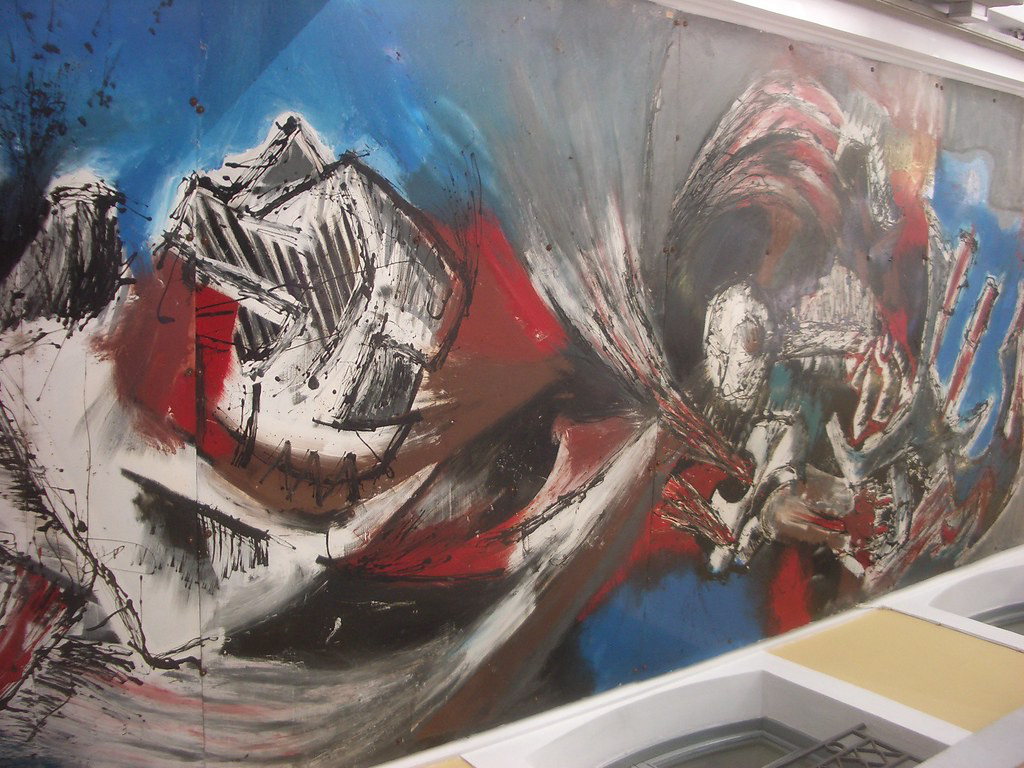

In [204]:
img

In [213]:
img_paths = list(Path('../input/training_images/').glob('*.jpg'))

0.4856064589330616


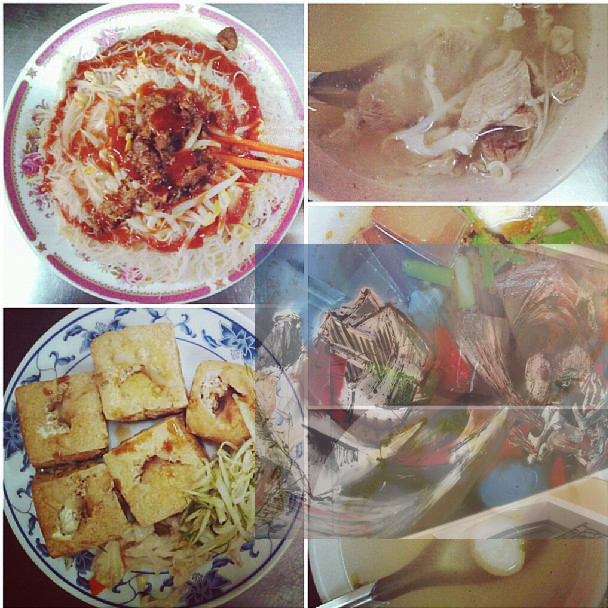

In [224]:
RandomOverlayImage(size_lower=0.2, size_upper=0.8, opacity_lower=0.6, img_paths=img_paths)(img)

In [142]:
from augly import utils

from PIL import ImageFont, ImageDraw

blacklist = []
for font_file in ro.font_list:
    local_font_path = str(Path(MODULE_BASE_DIR) / font_file)
    font = ImageFont.truetype(local_font_path, 30)
    try:
        pkl_file = os.path.splitext(font_file)[0] + ".pkl"
        local_pkl_path = utils.pathmgr.get_local_path(pkl_file)

        with open(Path(MODULE_BASE_DIR) / local_pkl_path, "rb") as f:
            chars = pickle.load(f)

        text_str = "".join([chr(chars[c % len(chars)]) for c in [0, 1]])

        draw = ImageDraw.Draw(img)
        color = [0,0,0]
        draw.text(
            xy=(0,0),
            text=text_str,
            fill=(color[0], color[1], color[2], round(1.0 * 255)),
            font=font,
        )
    except OSError:
        blacklist.append(local_font_path)

In [ ]:
blacklist = [
    'TypeMyMusic',
    'PainttheSky-Regular',
    'NotoSerifDevanagari-Regular',
    'NotoSansKaithi-Regular',
    'NotoSansPhagsPa-Regular',
    'NotoSansJavanese-Regular',
    'NotoSansMongolian-Regular',
    'NotoSansTibetan-Regular',
    'NotoSansTaiViet-Regular',
    'NotoSansCanadianAboriginal-Regular',
    'NotoSansTaiLe-Regular',
    'NotoSansCoptic-Regular',
    'NotoSansSaurashtra-Regular',
    'NotoSansThaana-Regulaf'
]

In [143]:
blacklist

[]

In [144]:
len(blacklist)

0

In [119]:
len(ro.font_list)

362

In [93]:
local_font_path

PosixPath('/home/shuhei.yokoo/anaconda3/envs/fbisc/lib/python3.7/site-packages/augly/assets/fonts/Allura-Regular.ttf')

In [90]:
from types import SimpleNamespace
args = SimpleNamespace()
args.input_size= 320

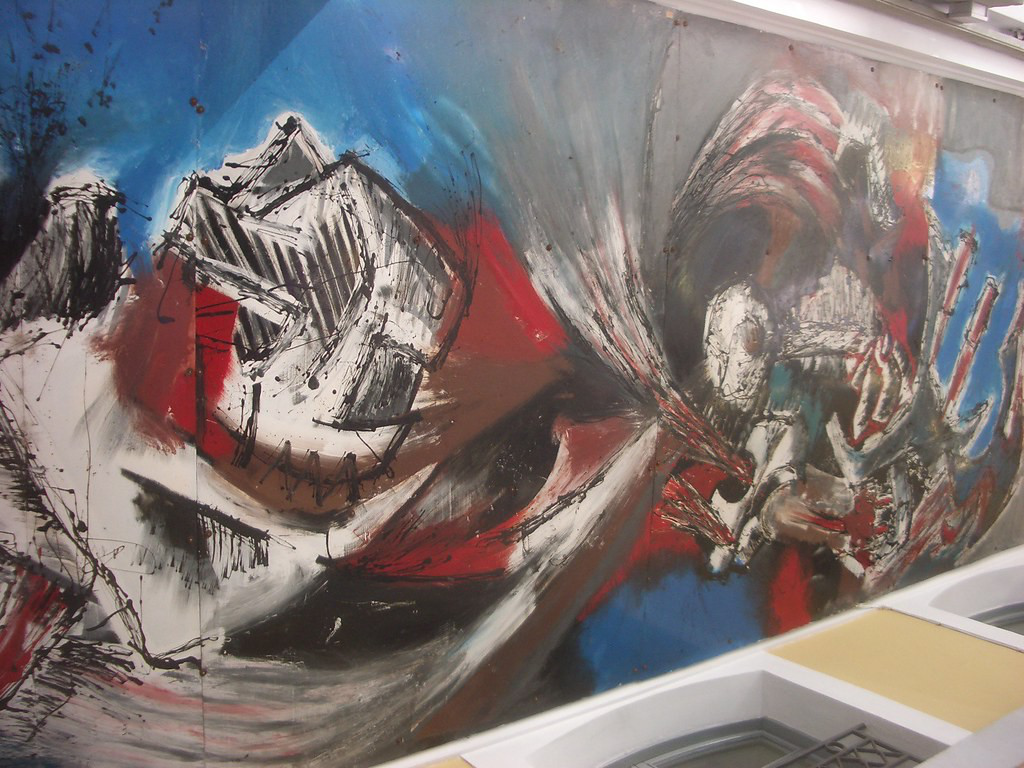

In [103]:
OverlayImage('/mnt/sdb/yokoo/fbisc/input/reference_images/R000000.jpg', overlay_size=1.0, x_pos=1.0, y_pos=1.0)(img)

In [113]:
OneOf([OneOf([transforms.RandomVerticalFlip(p=1), EncodingQuality(p=1)], p=0.1), transforms.RandomHorizontalFlip(p=1.0)])(img)

AssertionError: Expected instances of type `BaseTransform` or `BaseComposition` for variable `transforms`

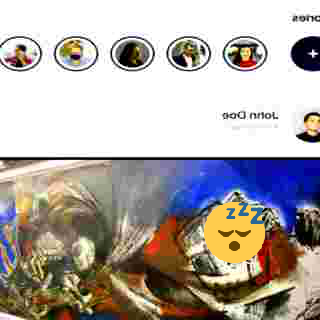

In [208]:
overlay1 = OverlayOntoScreenshot()
overlay2 = OverlayOntoScreenshot(template_filepath=overlay1.template_filepath.replace('web', 'mobile'))

transforms.Compose([
    OneOf([overlay1, overlay2], p=1.0),
    transforms.RandomResizedCrop(args.input_size, scale=(0.2, 1.)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    Saturation(factor=2.0, p=0.2),
    RandomBrightness(min_factor=0.5, max_factor=1.5, p=0.2),
    RandomPixelization(p=0.2),
    ShufflePixels(factor=0.1, p=0.2),
    OneOf([EncodingQuality(quality=q) for q in [10, 20, 30, 50]], p=0.5),
    transforms.RandomGrayscale(p=0.2),
    RandomBlur(p=0.2),
    transforms.RandomPerspective(p=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    RandomOverlayText(p=0.2),
    RandomEmojiOverlay(p=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(value='random', p=0.2),
    transforms.ToPILImage(),
])(img)

In [186]:
%debug

> /home/shuhei.yokoo/anaconda3/envs/fbisc/lib/python3.7/site-packages/torchvision/transforms/functional.py(335)normalize()
    333     if std.ndim == 1:
    334         std = std.view(-1, 1, 1)
--> 335     tensor.sub_(mean).div_(std)
    336     return tensor
    337 

ipdb> u
> /home/shuhei.yokoo/anaconda3/envs/fbisc/lib/python3.7/site-packages/torchvision/transforms/transforms.py(221)forward()
    219             Tensor: Normalized Tensor image.
    220         """
--> 221         return F.normalize(tensor, self.mean, self.std, self.inplace)
    222 
    223     def __repr__(self):

ipdb> u
> /home/shuhei.yokoo/anaconda3/envs/fbisc/lib/python3.7/site-packages/torch/nn/modules/module.py(1051)_call_impl()
   1049         if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks or _global_backward_hooks
   1050                 or _global_forward_hooks or _global_forward_pre_hooks):
-> 1051             return forward_call(*input, **kwargs)
   1052         # Do not c

torchvision.transforms.transforms.ColorJitter